# Kaggele group project 
This notebook includes all the code for the visualization, feature engineering, dimensionality reduction and model building.

In [53]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

### Introduction
The objective of this project is to categorize a geographical area into six distinct
labels using a dataset stored in a geojson file.
We’d like to highlight the challenge we faced while handling the geojson data file.
This file, considerably larger than the typical geojson file at around 100 MB, pre-
sented difficulties in terms of reading speed, with processing times extending up to
15 minutes. This raised concerns about potential kernel restarts, risking the loss of
data from memory. Despite experimenting with various techniques, including stream-
ing with geopandas and parallel processing with dask, the most effective approach
we discovered involved using the json library, coupled with subsequent conversion
to a GeoDataFrame. This method significantly reduced reading times to under two
minutes

In [54]:
#-- we read the GeoJSON files using with open
with open('train.geojson', 'r') as train_file:
    train_data = json.load(train_file)

with open('test.geojson', 'r') as test_file:
    test_data = json.load(test_file)

change_type_map = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
       'Mega Projects': 5}
#-- we convert to GeoDataFrame
train_df = gpd.GeoDataFrame.from_features(train_data)
test_df = gpd.GeoDataFrame.from_features(test_data)

The objective of this project is to categorize a geographical area into six distinct
labels using a dataset stored in a geojson file. The chosen evaluation metric is the
F1-score, representing the harmonic average of accuracy and precision. This metric is
particularly suitable for this problem, as depicted in the figure below, where the distribution
of labels is highly unbalanced. The conventional Accuracy-score might not be ideal
due to the inherent imbalance, where, for instance, a model consistently predicting
Residential would achieve a 50% accuracy.

In [55]:
import plotly.express as px
#--checking distribution balance
label_counts = train_df['change_type'].value_counts()
label_counts_df = pd.DataFrame({'label': label_counts.index, 'count': label_counts.values})
fig = px.pie(label_counts_df, names='label', values='count', title='Label Distribution')
fig.show()

### Data Cleaning
Let's start by looking if there are any missing values in our data

In [56]:
#--looking for missing values
missing_values_count_test = test_df.isnull().sum()
fig = px.bar(x=missing_values_count_test.index, y=missing_values_count_test.values, labels={'x': 'Features', 'y': 'Number of Missing Values'}, title='Number of missing values')
fig.show()

To solve this, we could just impute the missing values for the numerical features (img_mean & img_std) using the median on the whole data. However, we thought it would be commendable to imput a missing value accoring to the label it belongs to. In other words, say we have a missing value for `Img_red_std_date1` in a line that is labeled as `Demolition`. The missing value will be replaced by the median of `Img_red_std_date1` compouted on `Demolition` class only.

For the test set, we will impute the missing values by replacing them with the median computed on the **whole training set** and not the test set because otherwise we introduce biais to our model

#### Anomaly detection
Upon exploring our dataset, a peculiar observation emerged regarding the Demolition
label. Initially, we hypothesized that this label might exclusively possess the value
`Materials Dumped` in one of its `change_status_date` entries, as demolition processes typically involve deconstruction rather than construction. To validate this hypothesis, we visualized the outcomes in the figure below. 

In [57]:
def count_status(value_to_count):

    melted_df = pd.melt(train_df, id_vars=['change_type'], value_vars=['change_status_date0', 'change_status_date1', 'change_status_date2', 'change_status_date3', 'change_status_date4'])
    filtered_df = melted_df[melted_df['value'] == value_to_count]
    counts = filtered_df.groupby(['change_type', 'variable']).size().reset_index(name='count')
    return counts

#-- set the value to count
value_to_count = 'Materials Dumped'
fig = px.bar(count_status(value_to_count), x='change_type', y='count', color='variable', barmode='group', title=f'Count of {value_to_count}')
fig.show()

# stats_values = {'Land Cleared', None, 'Prior Construction', 'Construction Midway', 'Materials Dumped', 'Construction Done', 'Construction Started', 'Operational', 'Materials Introduced', 'Excavation', 'Greenland'}

Contrary to expectations, it became evident that the presence of the value `Materials Dumped` extends beyond cases classified under the `Demolition` label. To investigate further, we extended our analysis to include other values of the change
status date attributes.

In [58]:
fig1 = px.bar(count_status('Construction Done'), x='change_type', y='count', color='variable', barmode='group', title='Count of Construction Done')
fig1.show()
fig2 = px.bar(count_status('Construction Midway'), x='change_type', y='count', color='variable', barmode='group', title='Count of Construction Midway')
fig2.show()


Intriguingly, we observed occurrences of these values even within the `Demolition` label, which raised concerns.
Given the inherent objective of demolition processes, which is to dismantle rather than construct, the presence of these values in `Demolition` instances seems anomalous. Anyways, we won't go deeper into this and we'll move to engineering some features.

### Feature Engineering

#### Geometric features

#### Area, perimeter, shape and centroid feature

The initial geometry feature is given in the *'ESPG:4326'* format which gives the coordinates of a point in earth through its **latitude** and **longitude**.

To get the corresponding features like area, perimeter and lengths of each side, we had to project it into a flat surface by using the *Equal Area Cylindrical* projection.

In [59]:
train_df.crs = "epsg:4326"
test_df.crs = "epsg:4326"

# We use the area and length attributes of the GeoSeries to get the area and perimeter of the region
areas = train_df['geometry'].to_crs('+proj=cea').area
perimeters = train_df['geometry'].to_crs('+proj=cea').length

areas_t = test_df['geometry'].to_crs('+proj=cea').area
perimeters_t = test_df['geometry'].to_crs('+proj=cea').length

# Some areas may return none or inf value and need to be replaced 
for t in change_type_map:
    m = areas[train_df.change_type == t][areas[train_df.change_type == t].notna()].median()
    areas[train_df.change_type == t] = areas[train_df.change_type == t].fillna(m)
    m = perimeters[train_df.change_type == t][perimeters[train_df.change_type == t].notna()].median()
    perimeters[train_df.change_type == t] = perimeters[train_df.change_type == t].fillna(m)
    perimeters[train_df.change_type == t] = perimeters[train_df.change_type == t].apply(lambda x : x if np.isfinite(x) else m)

# We then save the new features in the train data frame
train_df['area'] = areas
train_df['perimeter'] = perimeters
train_df['shape'] = 4*np.sqrt(areas)/perimeters
train_df['area'] = areas/max(areas)
train_df['perimeter'] = perimeters/max(perimeters)

# We do the same with the test data frame
m = areas.median()
areas_t = areas_t.fillna(m)
m = perimeters.median()
perimeters_t  = perimeters_t.fillna(m)
m = train_df['perimeter'].max()
perimeters_t = perimeters_t.apply(lambda x : x if np.isfinite(x) else m )

test_df['area'] = areas_t
test_df['perimeter'] = perimeters_t
test_df['shape'] = 4*np.sqrt(areas_t)/perimeters_t
test_df['area'] = areas_t/max(areas_t)
test_df['perimeter'] = perimeters_t/max(perimeters_t)


# We can also find the corresponging longitude and latitude of centroid of each region 
train_df["lon"] = train_df["geometry"].centroid.x
train_df["lat"] = train_df["geometry"].centroid.y
test_df["lon"] = test_df["geometry"].centroid.x
test_df["lat"] = test_df["geometry"].centroid.y

c:\Users\sypha\AppData\Local\Programs\Python\Python310\lib\site-packages\shapely\measurement.py:44: RuntimeWarning:

invalid value encountered in area

c:\Users\sypha\AppData\Local\Programs\Python\Python310\lib\site-packages\shapely\measurement.py:182: RuntimeWarning:

invalid value encountered in length

C:\Users\sypha\AppData\Local\Temp\ipykernel_2656\1123114814.py:42: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\sypha\AppData\Local\Temp\ipykernel_2656\1123114814.py:43: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


C:\Users\sypha\AppData\Local\Temp\ipykernel_2656\1123114814.py:44: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' 

##### Length of longest and shortest side

In [60]:
from shapely.geometry import LineString

def calculate_segment_lengths(geometry):
    boundary = geometry.exterior
    
    # Get the coordinates of the boundary
    coords = list(boundary.coords)
    # Calculate the length of each segment
    segment_lengths = [LineString([coords[i], coords[i+1]]).length for i in range(len(coords)-1)]
    # Calculate the length of the longest and shortest segments
    longest_segment_length = max(segment_lengths)
    shortest_segment_length = min(segment_lengths)

    return [longest_segment_length, shortest_segment_length, shortest_segment_length/longest_segment_length]

new_feats = train_df['geometry'].apply(calculate_segment_lengths)
train_df[['max_len','min_len','min_over_max']] = pd.DataFrame({ 'max_len' : [l[0] for l in new_feats], 'min_len' : [l[1] for l in new_feats], 'min_over_max' : [l[-1] for l in new_feats]})
new_feats = test_df['geometry'].apply(calculate_segment_lengths)
test_df[['max_len','min_len','min_over_max']] = pd.DataFrame({ 'max_len' : [l[0] for l in new_feats], 'min_len' : [l[1] for l in new_feats], 'min_over_max' : [l[-1] for l in new_feats]})

##### Plots of area, perimeter and shape features

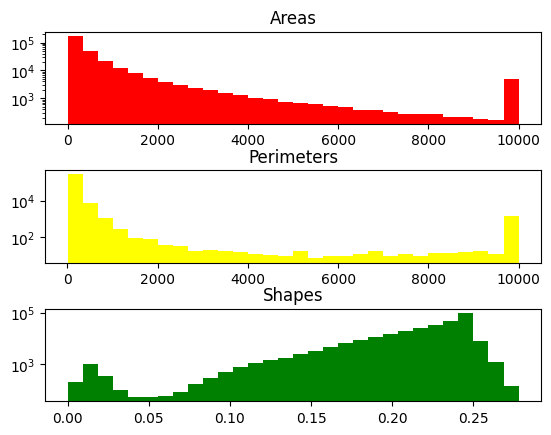

In [61]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1)

axs[0].hist(areas.apply(lambda x: x - (x >= 10000) * (x - 10000)), bins=30, color='red')
axs[0].set_yscale('log')
axs[0].set_title('Areas')

axs[1].hist(perimeters.apply(lambda x: x - (x >= 10000) * (x - 10000)), bins=30, color='yellow')
axs[1].set_yscale('log')
axs[1].set_title('Perimeters')

axs[2].hist(areas**(1/2) / perimeters, bins=30, color='green')
axs[2].set_yscale('log')
axs[2].set_title('Shapes')
plt.subplots_adjust(hspace=0.5)
plt.show()

We can see that these distributions have good variance so we do gain information by creating these three features.

#### Neighborhood features

For the urban and geographical types we use a **one-hot** encoding

In [62]:
# We retreive the set of different values of geography_type and urban_type
urban = set(train_df.urban_type.values.flatten())
geography = set(train_df.geography_type.values.flatten())
urban = [ a.split(',') if a!='N,A' else ['N,A'] for a in urban ]
geography = [ a.split(',') if a!='N,A' else ['N,A'] for a in geography ]
s = set()
for a in urban:
    for b in a:
        s.add(b)
urban = s
s = set()
for a in geography:
    for b in a:
        s.add(b)
geography = s

# Encoding with get_dummies()
hot_one = train_df['geography_type'].apply(func= lambda x : x.replace(',','|') if x!= 'N,A' else 'N,A' ).str.get_dummies()
train_df[hot_one.keys()] = hot_one
hot_one = train_df['urban_type'].apply(func= lambda x : x.replace(',','|') if x!= 'N,A' else 'N,A' ).str.get_dummies()
train_df[hot_one.keys()] = hot_one
hot_one = test_df['geography_type'].apply(func= lambda x : x.replace(',','|') if x!= 'N,A' else 'N,A' ).str.get_dummies()
test_df[hot_one.keys()] = hot_one
hot_one = test_df['urban_type'].apply(func= lambda x : x.replace(',','|') if x!= 'N,A' else 'N,A' ).str.get_dummies()
test_df[hot_one.keys()] = hot_one

#### Date features

We can easily chack that the dates given are not following the chronological order. We than proceed to order them and convert them to the number of days since the start.

By doing that we also need to rearange the other time dependent features

In [63]:
# The color features range from date1 to date5, we just rename them to range from date0 to date4 like all the other time related features
if not('img_red_mean_date0' in test_df.keys()): # this is used to not encouter an arror if we run this section more than once
    for i in range(5):
        test_df = test_df.rename(columns= {f'img_red_mean_date{i+1}' : f'img_red_mean_date{i}',f'img_green_mean_date{i+1}':f'img_green_mean_date{i}',f'img_blue_mean_date{i+1}':f'img_blue_mean_date{i}',f'img_red_std_date{i+1}':f'img_red_std_date{i}',f'img_green_std_date{i+1}':f'img_green_std_date{i}',f'img_blue_std_date{i+1}':f'img_blue_std_date{i}'})
        train_df = train_df.rename(columns= {f'img_red_mean_date{i+1}' : f'img_red_mean_date{i}',f'img_green_mean_date{i+1}':f'img_green_mean_date{i}',f'img_blue_mean_date{i+1}':f'img_blue_mean_date{i}',f'img_red_std_date{i+1}':f'img_red_std_date{i}',f'img_green_std_date{i+1}':f'img_green_std_date{i}',f'img_blue_std_date{i+1}':f'img_blue_std_date{i}'})

# This is used to get all the time related features
features0 = list(train_df.keys())
date_features0 = [ f for f in features0 if 'date' in f if f!= 'date_ref'] # the 'date_ref' is excluded to not encouter an arror if we run this section more than once
dates = ['date0','date1','date2','date3','date4']

# format des dates de DD-MM-YYYY à YYYY-MM-DD
for i in range(5):
    if isinstance(train_df[f'date{i}'][0],str) and train_df[f'date{i}'][0][2] == '-':
        train_df[f'date{i}'] = train_df[f'date{i}'].apply(lambda x: x[6:10]+'-'+x[3:5]+'-'+x[0:2] if isinstance(x,str) else None)
    if isinstance(test_df[f'date{i}'][0],str) and test_df[f'date{i}'][0][2] == '-':
        test_df[f'date{i}'] = test_df[f'date{i}'].apply(lambda x: x[6:10]+'-'+x[3:5]+'-'+x[0:2] if isinstance(x,str) else None)

# for the train set

# replace empty values from train set
m = {'date0' : '2013-01-01','date1' : '2014-01-01','date2' : '2015-01-01','date3' : '2016-01-01','date4' : '2017-01-01'}
for d in dates:
     train_df[d] = train_df[d].fillna(m[d])

# convert to datetime then days from the starting day
if not('date_ref' in train_df.keys()):
    train_df['date_ref'] = pd.to_datetime(train_df[dates].apply(lambda x : x.apply(lambda x : str(x)).min() ,axis = 1))
else:
    train_df['date_ref'] = pd.to_datetime(train_df['date0'])
for i in range(5):
    if not(isinstance(train_df[f'date{i}'][0],np.float64)) and not(isinstance(train_df[f'date{i}'][0],np.int64)) :
        train_df[f'date{i}'] = (pd.to_datetime(train_df[f'date{i}']) - train_df['date_ref']).dt.days

# hronological order for train
def order_dates(row):
    row_dates = np.array(row[dates])
    row_dates_sort = row_dates.copy()
    row_dates_sort.sort()
    date_map = { np.argwhere( row_dates_sort == row_dates[i])[0][0] : i for i in range(5)}
    return np.array(row[[ d[:-1] + f'{date_map[int(d[-1])]}' for d in date_features0]])

train_df[date_features0] = pd.DataFrame(train_df.loc[0:len(train_df),date_features0].apply(lambda x : order_dates(x), axis = 1, result_type='expand')).rename(columns={ i : date_features0[i] for i in range(len(date_features0))})

# for test set

# replace empty values in test set
for d in dates:
     test_df[d] = test_df[d].fillna(m[d])

# convertir to datetime then days from the start
if not('date_ref' in test_df.keys()):
    test_df['date_ref'] = pd.to_datetime(test_df[dates].apply(lambda x : x.apply(lambda x : str(x)).min() ,axis = 1))
else:
    test_df['date_ref'] = pd.to_datetime(test_df['date0'])
for i in range(5):
    if not(isinstance(test_df[f'date{i}'][0],np.float64)) and not(isinstance(test_df[f'date{i}'][0],np.int64))  :
        test_df[f'date{i}'] = (pd.to_datetime(test_df[f'date{i}']) - test_df['date_ref']).dt.days

# chronological order for the test
test_df[date_features0] = pd.DataFrame(test_df.loc[0:len(test_df),date_features0].apply(lambda x : order_dates(x), axis = 1, result_type='expand')).rename(columns={ i : date_features0[i] for i in range(len(date_features0))})

test_df[dates]=test_df[dates]/3000
train_df[dates]=train_df[dates]/3000

#### Change_status features

We use a **one-hot** encoding but we also add a frequency column for each unique value of change_status

In [64]:
# one-hit encoding of change_status features
status = ['change_status_date0','change_status_date1','change_status_date2','change_status_date3','change_status_date4']
change_status = [] # this is used to retreive the different features
for i in range(1,5):
    hot_one = train_df[status[i]].str.get_dummies()
    train_df[[f'{s}_{i}' for s in hot_one.keys()]] = hot_one
    hot_one = test_df[status[i]].str.get_dummies()
    test_df[[f'{s}_{i}' for s in hot_one.keys()]] = hot_one
    change_status += [f'{s}_{i}' for s in hot_one.keys()]

# frequencies of each unique value of change_status
hot_one = train_df[status[0]].str.get_dummies()
for i in range(1,5):
    hot_one += train_df[status[i]].str.get_dummies()
train_df[hot_one.keys()] = hot_one/5

hot_one = test_df[status[0]].str.get_dummies()
for i in range(1,5):
    hot_one += test_df[status[i]].str.get_dummies()
test_df[hot_one.keys()] = hot_one/5

#### Color features

Beacause of the large number of color features, we perform a PCA to get from thirty features to seven principal components and therby avoid the curse of dimensionality. 

In [65]:
color_features= ['img_red_mean_date1', 'img_green_mean_date1', 'img_blue_mean_date1',
       'img_red_std_date1', 'img_green_std_date1', 'img_blue_std_date1',
       'img_red_mean_date2', 'img_green_mean_date2', 'img_blue_mean_date2',
       'img_red_std_date2', 'img_green_std_date2', 'img_blue_std_date2',
       'img_red_mean_date3', 'img_green_mean_date3', 'img_blue_mean_date3',
       'img_red_std_date3', 'img_green_std_date3', 'img_blue_std_date3',
       'img_red_mean_date4', 'img_green_mean_date4', 'img_blue_mean_date4',
       'img_red_std_date4', 'img_green_std_date4', 'img_blue_std_date4',
       'img_red_mean_date0', 'img_green_mean_date0', 'img_blue_mean_date0',
       'img_red_std_date0', 'img_green_std_date0', 'img_blue_std_date0']

# replace the missing values with the median
y = train_df[color_features][train_df['img_red_std_date3'].notna()].median(axis = 0)
train_df.loc[train_df['img_red_std_date3'].isna(),color_features] = train_df.loc[train_df['img_red_std_date3'].isna(),color_features].apply(lambda x : y,axis = 1)
y = train_df[color_features][train_df['img_red_std_date3'].notna()].median(axis = 0)
test_df.loc[test_df['img_red_std_date3'].isna(),color_features] = test_df.loc[test_df['img_red_std_date3'].isna(),color_features].apply(lambda x : y,axis = 1)

In [66]:
train_df[color_features]=train_df[color_features]/255
test_df[color_features]=test_df[color_features]/255

In [67]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Select subset of features
selected_features = train_df[color_features]
selected_features_test= test_df[color_features]

# Step 2: Standardize the selected features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selected_features)
scaled_features_test= scaler.transform(selected_features_test)
# Step 3: Perform PCA
pca = PCA()
pca.fit(scaled_features)

# Step 4: Determine the number of principal components needed to preserve 80% of the variance
explained_variance_ratio_cumsum = pca.explained_variance_ratio_.cumsum()
k = (explained_variance_ratio_cumsum >= 0.8).argmax() + 1

# Step 5: Apply dimensionality reduction
pca = PCA(n_components=k)
transformed_features = pca.fit_transform(scaled_features)
transformed_features_test = pca.transform(scaled_features_test)


# Create a DataFrame with the transformed features
train_df[[f'PC{i+1}' for i in range(k)]] = pd.DataFrame(transformed_features, columns=[f'PC{i+1}' for i in range(k)])
test_df[[f'PC{i+1}' for i in range(k)]] =  pd.DataFrame(transformed_features_test, columns=[f'PC{i+1}' for i in range(k)])


#### Advancement Status

This custom feature allows to determine weither or not we advanced in the Construction throughout the different dates. In the case of underterminable status we return 0.

It can be usefull to discriminate between Demolition and other change_type

In [68]:
status = ['change_status_date0','change_status_date1','change_status_date2','change_status_date3','change_status_date4']

# the status are mapped to numbers representing their level of advencement in a Construction site, Construction Done being the highest and Greenland the lowest
status_map = {'Greenland' : 1, 'Land Cleared' : 2,'Construction Started' : 3,'Construction Midway' : 4,'Construction Done' : 5, 'Operational' : 5, 'Prior Construction':5,'Excavation' : 1,'Materials Dumped' : 3,'Materials Introduced':3 , None : 0 }

def adv(row):
    a = status_map[row['change_status_date0']] #first status
    b = status_map[row['change_status_date4']] #last status
    max = 0 # max status
    min = 5 # min status
    if row['change_status_date4'] == 'Material Dumped': # this is a particular case because most of the 'Material Dumped' correspond to 'Commercial'
        return 3
    if sum(row.isna()) != 0:
        return 0
    for s in status:
        if status_map[row[s]]>max:
            max = status_map[row[s]]
        if status_map[row[s]]<min:
            min = status_map[row[s]]
    
    if (max == 5 and (max - b)>=2):
        return -1
    elif (min >= 3 and a - b<2) or (b >= 3 and max == b and min < 3) or (b-min)>2 or (max == b and min == a):
        return 1
    elif b<=2 or (a>=3 and a-min >1):
        return -1
    else:
        return 0

train_df['adv'] = train_df[['change_status_date0','change_status_date1','change_status_date2','change_status_date3','change_status_date4']].apply(adv,axis = 1)
test_df['adv'] = test_df[['change_status_date0','change_status_date1','change_status_date2','change_status_date3','change_status_date4']].apply(adv,axis = 1)

In [69]:
print(f"True negative for Demolition : {sum(train_df[train_df['change_type'] == 'Demolition']['adv'] == -1)/len(train_df[train_df['change_type'] == 'Demolition'])}")
print(f"False negative for others    : {sum(train_df[train_df['change_type'] != 'Demolition']['adv'] == -1)/len(train_df[train_df['change_type'] != 'Demolition'])}")

True negative for Demolition : 0.9629629629629629
False negative for others    : 0.06696720413245313


#### Project duration

With this feature we give the duration of a construction for the ones where the construction is clearly advancing and 0 otherwise.

In [70]:
status_map = {'Greenland' : 1, 'Land Cleared' : 2,'Construction Started' : 3,'Construction Midway' : 4,'Construction Done' : 5, 'Operational' : 5, 'Prior Construction':5,'Excavation' : 1,'Materials Dumped' : 3,'Materials Introduced':3 , None : 0 }
status = ['change_status_date0','change_status_date1','change_status_date2','change_status_date3','change_status_date4']
dates = ['date0','date1','date2','date3','date4']

def durée(row):
    step = [status_map[row[s]] for s in status ]
    m = 0 # the first satus from which the construction started
    for i in range(4):
        if step[i+1] == step[i] and m == i: # check if the constuction started or not
            m = i+1
        if step[i+1]-step[i]>=0: # check if the construction is advancing
            if step[i+1] == 5 or (i+1 == 5 and step[i+1]>=3): # check if the construction is finished or almost finished at the last date
                return row[f'date{i+1}'] - row[f'date{m}']
        else:
            return 0
    return 0

train_df['duree'] = train_df[status + dates].apply(durée,axis=1)
test_df['duree'] = test_df[status + dates].apply(durée,axis=1)

In [ ]:
# save the modifications
train_df.to_file('train_df.geojson', driver='GeoJSON')
test_df.to_file('test_df.geojson', driver='GeoJSON')

### Model

After the preprocessig of our data and the feature engineering, we'll delve into the model evaluation. First of all, we load the preprocessed data saved earlier.

In [ ]:
import geopandas as gpd
import json

# load the data
change_type_map = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
       'Mega Projects': 5}

# Read GeoJSON files using with open
with open('train_df.geojson', 'r') as train_file:
    train_data = json.load(train_file)

with open('test_df.geojson', 'r') as test_file:
    test_data = json.load(test_file)

# Convert to GeoDataFrame
train_df = gpd.GeoDataFrame.from_features(train_data)
test_df = gpd.GeoDataFrame.from_features(test_data)

train_y = train_df['change_type'].apply(lambda x: change_type_map[x])

Now, we redefine the features that we are going to use on our models.

In [72]:
# Modelling

color_features= ['img_red_mean_date1', 'img_green_mean_date1', 'img_blue_mean_date1',
       'img_red_std_date1', 'img_green_std_date1', 'img_blue_std_date1',
       'img_red_mean_date2', 'img_green_mean_date2', 'img_blue_mean_date2',
       'img_red_std_date2', 'img_green_std_date2', 'img_blue_std_date2',
       'img_red_mean_date3', 'img_green_mean_date3', 'img_blue_mean_date3',
       'img_red_std_date3', 'img_green_std_date3', 'img_blue_std_date3',
       'img_red_mean_date4', 'img_green_mean_date4', 'img_blue_mean_date4',
       'img_red_std_date4', 'img_green_std_date4', 'img_blue_std_date4',
       'img_red_mean_date0', 'img_green_mean_date0', 'img_blue_mean_date0',
       'img_red_std_date0', 'img_green_std_date0', 'img_blue_std_date0']
urban = set(train_df.urban_type.values.flatten())
geography = set(train_df.geography_type.values.flatten())
urban = [ a.split(',') if a!='N,A' else ['N,A'] for a in urban ]
geography = [ a.split(',') if a!='N,A' else ['N,A'] for a in geography ]
s = set()
for a in urban:
    for b in a:
        s.add(b)
urban = s
s = set()
for a in geography:
    for b in a:
        s.add(b)
geography = s

In [73]:
features = ['duree'] + [g for g in geography if g!='N,A'] + [u for u in urban if u!='N,A'] + ['area','perimeter','shape','Construction Done','Construction Midway','Construction Started','Excavation','Greenland','Land Cleared','Materials Dumped','Materials Introduced','Operational','Prior Construction'] + ['adv'] + ['min_len','max_len','min_over_max'] + ['lon','lat']

## Models benchmark

Given the nature of the classification problem, we have chosen to concenterate on the Ensemble learning algorithmes. Therefore, in this part, we'll explore and compare the performance of the following algorithms: Random Forest and XGBoost. For each model, we have adopted a cross-validation approach where we divide randomly our training dataset to training set (80%) and validtaion set (20%). Then, we conduct several simulations using diffrent hyperparameters. Finally we choose the best hyperparameters based on the weighted F1-score on validation set. After choosing the best hyperparameters, we train our model using the whole training set.

### Random Forest

First of all, we classifier. After several simulations with diffrent hyperparameters using cross-validation, we found the following hypermaters which yield the best performance on the validation set.

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_y, test_size=0.05, stratify=train_y, random_state=42)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=60, max_depth=30, random_state=42)
rf_classifier.fit(X_train, y_train)

# Evaluate on the training set
train_pred_y = rf_classifier.predict(X_train)
train_f1 = f1_score(y_train, train_pred_y, zero_division=1.0, labels=[0,1,2,3,4,5], average='weighted')
train_accuracy = accuracy_score(y_train, train_pred_y)
print("Training F1 Score:", train_f1)
print("Training Accuracy:", train_accuracy)

# Evaluate on the validation set
val_pred_y = rf_classifier.predict(X_test)
val_f1 = f1_score(y_test, val_pred_y, zero_division=1.0, labels=[0,1,2,3,4,5], average='weighted')
val_accuracy = accuracy_score(y_test, val_pred_y)
print("Validation F1 Score:", val_f1)
print("Validation Accuracy:", val_accuracy)


Training F1 Score: 0.9877481323944058
Training Accuracy: 0.9876909624721865
Validation F1 Score: 0.7528666686278858
Validation Accuracy: 0.7560777957860616


After chosing the best hyperparamers, we train our model on all the training set.

In [78]:
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
rf_classifier.fit(train_df[features], train_y)

RandomForestClassifier(max_depth=20, random_state=42)

Finally, we use the model to predict the classes in the test set and we save the resluts.

In [79]:
y_pred = rf_classifier.predict(test_df[features])
pred_df = pd.DataFrame(y_pred, columns=['change_type'])
pred_df.to_csv("rf_classifier_172_4.csv", index=True, index_label='Id')

### XGBoost Classifier

We'll consider now the XGBoost classifier. After several simulations with diffrent hyperparameters using cross-validation, we found the following hypermaters which yield the best performance on the validation set.

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier
import pandas as pd

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_y, test_size=0.05, stratify=train_y, random_state=42)

# Train an XGBoost classifier
xgb_classifier = XGBClassifier(n_estimators=100, max_depth=20, random_state=42)
xgb_classifier.fit(X_train, y_train)

# Evaluate on the training set
train_pred_y = xgb_classifier.predict(X_train)
train_f1 = f1_score(y_train, train_pred_y, zero_division=1.0, labels=[0,1,2,3,4,5], average='weighted')
train_accuracy = accuracy_score(y_train, train_pred_y)
print("Training F1 Score:", train_f1)
print("Training Accuracy:", train_accuracy)

# Evaluate on the validation set
val_pred_y = xgb_classifier.predict(X_test)
val_f1 = f1_score(y_test, val_pred_y, zero_division=1.0, labels=[0,1,2,3,4,5], average='weighted')
val_accuracy = accuracy_score(y_test, val_pred_y)
print("Validation F1 Score:", val_f1)
print("Validation Accuracy:", val_accuracy)

# saving the trained model to be used later in the confusion matrix 
xgb_classifier_training=xgb_classifier


Training F1 Score: 0.9999893366323246
Training Accuracy: 0.9999893366697709
Validation F1 Score: 0.7594111185920264
Validation Accuracy: 0.7616828741220961


After chosing the best hyperparamers, we train our model on all the training set.

In [81]:
xgb_classifier = XGBClassifier(n_estimators=100, max_depth=20, random_state=42)
xgb_classifier.fit(train_df[features], train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Finally, we use the model to predict the classes in the test set and we save the resluts.

In [82]:
y_pred = xgb_classifier.predict(test_df[features])
pred_df = pd.DataFrame(y_pred, columns=['change_type'])
pred_df.to_csv("xgb_classifier_172_4.csv", index=True, index_label='Id')

## Conclusion

After observing the performance of both models, we have decided to finally choose XGBoost Classifier as we have noticed that it has a slight edge over Random Forest in both validation and testing (using the Kaggle submissions). Finally, we have plotted the confusion matrix of the model (trained on the 0.8) to investigate the difficult classes for the model.

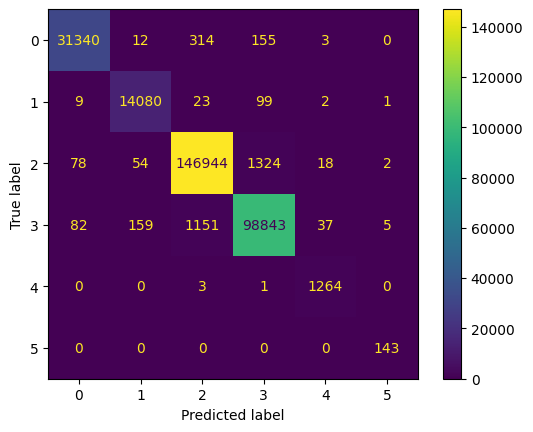

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(xgb_classifier_training.predict(train_df[features]),train_y)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

### Thanks for reading !!!